# Exploration Notebook

This notebook is used for exploratory data analysis and experimentation with the audio dataset. It includes sections for loading data, visualizing audio signals, and testing model components.

In [ ]:
# Import necessary libraries
import os
import numpy as np
import pandas as pd
import torchaudio
import matplotlib.pyplot as plt
from src.data.dataset import AudioDataset
from src.utils.visualization import plot_waveform, plot_spectrogram

# Set up paths
DATA_DIR = "path/to/your/data"

# Load dataset
dataset = AudioDataset(DATA_DIR)

# Explore the dataset
print(f"Total samples: {len(dataset)}")
print(f"Example sample: {dataset[0]}")

# Visualize an audio sample
sample_rate, audio_data = dataset[0]
plot_waveform(audio_data, sample_rate)
plt.title("Waveform of Sample 0")
plt.show()

# Visualize the spectrogram
plot_spectrogram(audio_data, sample_rate)
plt.title("Spectrogram of Sample 0")
plt.show()

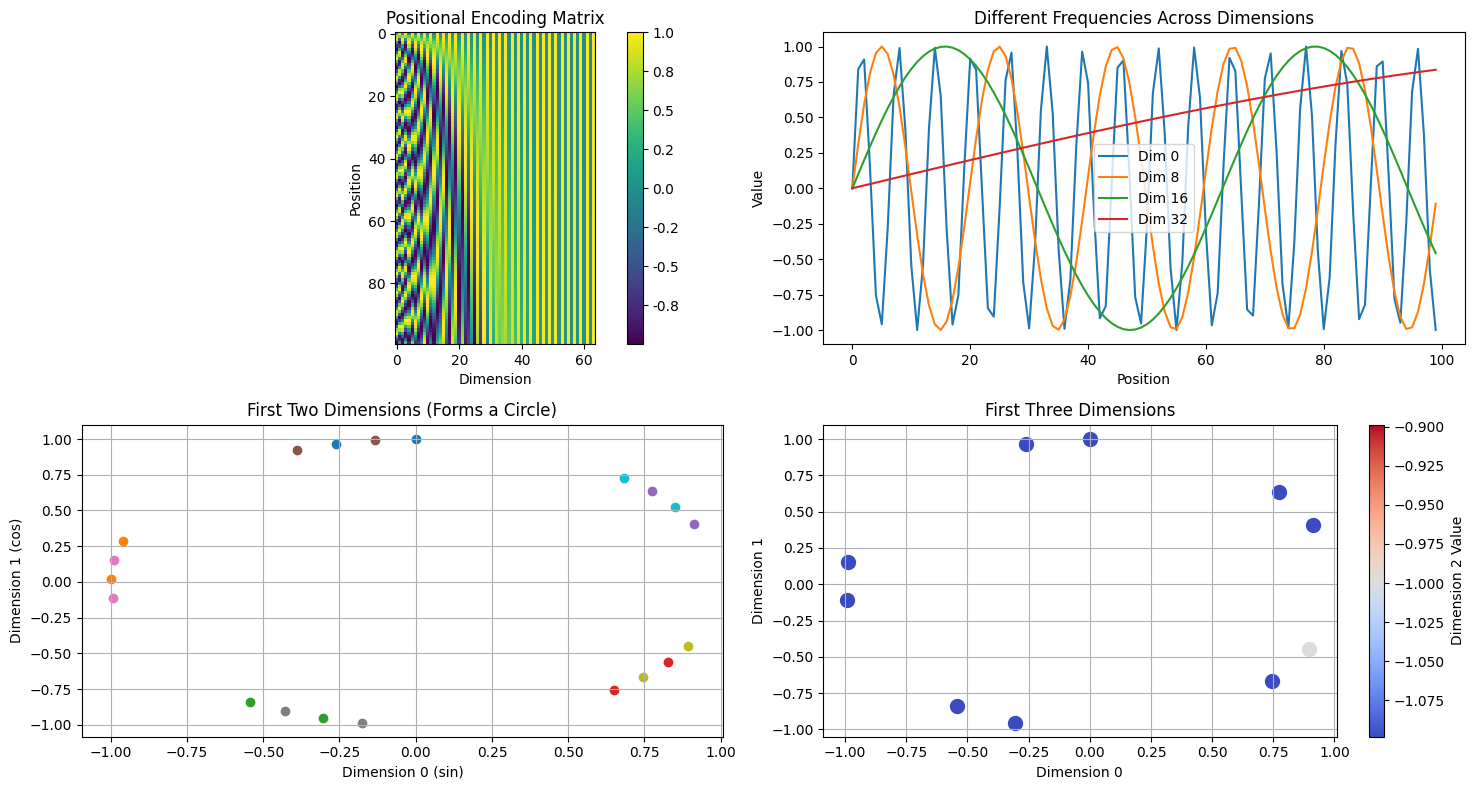

In [4]:
import numpy as np
import matplotlib.pyplot as plt

def positional_encoding(seq_length, d_model):
    positions = np.arange(seq_length)[:, np.newaxis]
    depths = np.arange(d_model)[np.newaxis, :]
    
    angle_rates = 1 / np.power(10000, (2 * (depths//2)) / np.float32(d_model))
    angle_rads = positions * angle_rates
    
    # Apply sin to even indices, cos to odd indices
    pos_encoding = np.zeros(shape=(seq_length, d_model))
    pos_encoding[:, 0::2] = np.sin(angle_rads[:, 0::2])
    pos_encoding[:, 1::2] = np.cos(angle_rads[:, 1::2])
    
    return pos_encoding

# Create positional encodings
seq_length = 100
d_model = 64
encodings = positional_encoding(seq_length, d_model)

# Visualization
plt.figure(figsize=(15, 8))

# 1. Heatmap visualization of the entire encoding
plt.subplot(2, 2, 1)
plt.imshow(encodings, cmap='viridis')
plt.colorbar(format='%.1f')
plt.title('Positional Encoding Matrix')
plt.xlabel('Dimension')
plt.ylabel('Position')

# 2. Plot a few dimensions to show frequency differences
plt.subplot(2, 2, 2)
dimensions = [0, 8, 16, 32]
for dim in dimensions:
    plt.plot(encodings[:, dim], label=f'Dim {dim}')
plt.legend()
plt.title('Different Frequencies Across Dimensions')
plt.xlabel('Position')
plt.ylabel('Value')

# 3. Plot two dimensions to show circular pattern
plt.subplot(2, 2, 3)
positions = np.arange(0, seq_length, 5)
for pos in positions:
    plt.scatter(encodings[pos, 0], encodings[pos, 1], label=f'Pos {pos}')
plt.title('First Two Dimensions (Forms a Circle)')
plt.xlabel('Dimension 0 (sin)')
plt.ylabel('Dimension 1 (cos)')
plt.grid(True)
if pos < 30:  # Only show legend if we have a reasonable number of points
    plt.legend()

# 4. 3D visualization using three dimensions
plt.subplot(2, 2, 4)
for i in range(0, seq_length, 10):
    plt.scatter(encodings[i, 0], encodings[i, 1], c=encodings[i, 2], 
                cmap='coolwarm', s=100, label=f'Pos {i}')
plt.colorbar(label='Dimension 2 Value')
plt.title('First Three Dimensions')
plt.xlabel('Dimension 0')
plt.ylabel('Dimension 1')
plt.grid(True)

plt.tight_layout()
plt.show()

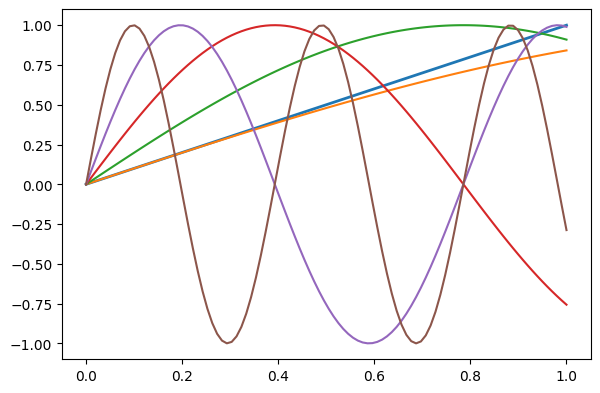

In [14]:
# set parent module path
import sys
import os
#__file__ does not work in jupyter notebooks
sys.path.append(os.path.abspath(os.path.join('..')))


from src.models.encoding import PositionalEncoder
import torch
# Create a visualization
def visualize_positional_encoding():
    # Parameters
    multires = 5  # Number of frequency bands
    no_channels = 1  # Mono audio
    
    # Create the encoder
    encoder = PositionalEncoder(multires, no_channels)
    
    # Generate sample inputs (position values from 0 to 1)
    positions = torch.linspace(0, 1, 100).unsqueeze(-1)  # [100, 1]
    
    # Apply positional encoding
    with torch.no_grad():
        encoded = encoder(positions)
    
    # Convert to numpy for plotting
    positions_np = positions.numpy().flatten()
    encoded_np = encoded.numpy()
    
    # Plotting
    plt.figure(figsize=(15, 10))
    
    # 1. Plot the original signal and encoded dimensions
    plt.subplot(2, 2, 1)
    plt.plot(positions_np, positions_np, label='Original Input', linewidth=2)
    
    # Plot a few of the encoded dimensions
    for i in range(1, min(6, encoded.shape[1])):
        plt.plot(positions_np, encoded_np[:, i], 
                 label=f'{"sin" if i%2==1 else "cos"} freq={encoder.freq_bands[i//2 if i>1 else 0]:.1f}')
        
visualize_positional_encoding()

With very long sequences → Higher frequency PEs are required

- To distinguish positions across long sequences, you need higher frequency components.

- But high-frequency sinusoids start to alias or overlap due to periodicity — they no longer uniquely identify positions unless the embedding dimension is sufficiently large.


the hypothesis is wrong

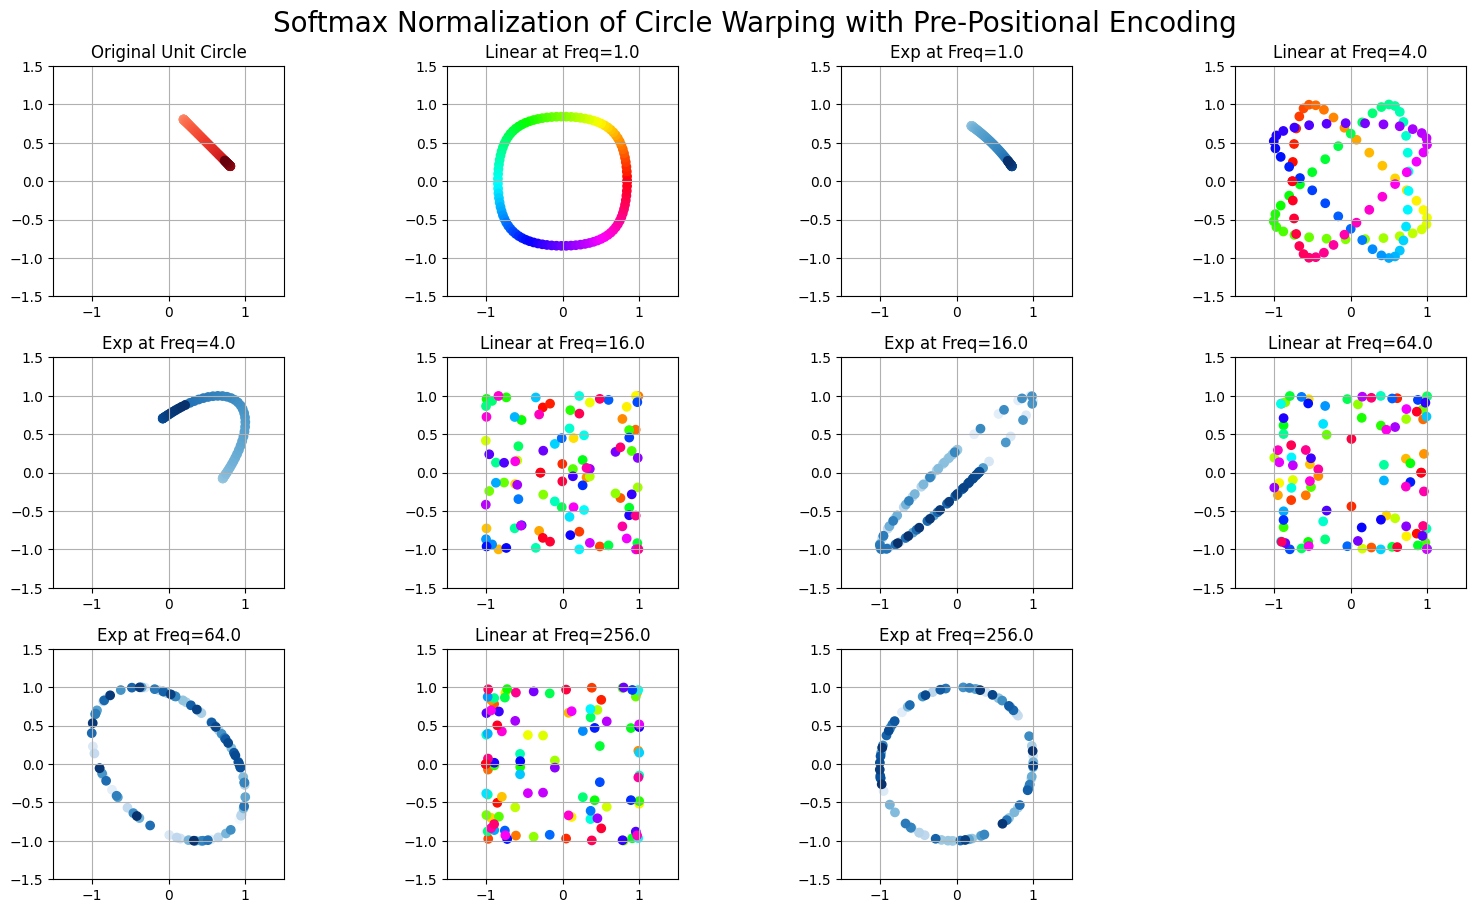

In [53]:
from torch.nn import functional as F
# Create a visualization of how the unit circle is warped
def visualize_circle_warping():
    # Parameters
    multires = 10
    
    # Create the encoder
    encoder = PositionalEncoder(multires, no_channels=2)  # 2D inputs
    
    # Generate points on a unit circle
    theta = torch.linspace(0, 2*np.pi, 100)
    x = torch.cos(theta)
    y = torch.sin(theta)
    circle_points = torch.stack([x, y], dim=1)  # [100, 2]
    
    # Apply positional encoding
    with torch.no_grad():
        encoded = encoder(circle_points)
        circle_points = F.softmax(circle_points, dim=-1) # USING SOFTMAX IN NORMALIZATION
        high_freq_encoded = encoder(circle_points)
    
    # Convert to numpy for plotting
    circle_np = circle_points.numpy()
    encoded_np = encoded.numpy()
    high_freq_encoded_np = high_freq_encoded.numpy()
    
    # Create plot
    fig = plt.figure(figsize=(16, 12))
    
    # Original circle
    ax1 = fig.add_subplot(4, 4, 1)
    ax1.scatter(circle_np[:, 0], circle_np[:, 1], c=theta.numpy(), cmap='Reds')
    ax1.set_title('Original Unit Circle')
    ax1.set_xlim([-1.5, 1.5])
    ax1.set_ylim([-1.5, 1.5])
    ax1.set_aspect('equal')
    ax1.grid(True)

    # Plot warping at different frequency bands
    for i in range(10):
        if i % 2 != 0:
            continue
        # For each frequency band, plot the circle warped by sin(freq*x), sin(freq*y)
        ax = fig.add_subplot(4, 4, (i)+2)
        
        freq = encoder.freq_bands[i].item()
        # Get the sin features for this frequency band
        idx_x = 2 + i  # Skip the original inputs (2) and get the sin feature
        idx_y = 2 + multires + i  # Skip to the next set of features for y
        
        # Extract the warped coordinates
        x_warped = encoded_np[:, idx_x]
        y_warped = encoded_np[:, idx_y]
        
        x_high_freq = high_freq_encoded_np[:, idx_x]
        y_high_freq = high_freq_encoded_np[:, idx_y]
		
		# Plot the warped circle
        ax.scatter(x_warped, y_warped, c=theta.numpy(), cmap='hsv')
        ax.set_title(f'Linear at Freq={freq:.1f}')
        ax.set_aspect('equal')
        ax.grid(True)
        ax.set_xlim([-1.5, 1.5])
        ax.set_ylim([-1.5, 1.5])

		# Plot the high frequency encoding
        ax2 = fig.add_subplot(4, 4, (i)+3)
        ax2.scatter(x_high_freq, y_high_freq, c=theta.numpy(), cmap='Blues')
        ax2.set_title(f'Exp at Freq={freq:.1f}')
        ax2.set_xlim([-1.5, 1.5])
        ax2.set_ylim([-1.5, 1.5])
        ax2.set_aspect('equal')
        ax2.grid(True)
    
    # set title
    plt.suptitle('Softmax Normalization of Circle Warping with Pre-Positional Encoding', fontsize=20)
    plt.tight_layout()
    plt.show()


# Run the visualization
visualize_circle_warping()